# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [1]:
print ('test')

test


In [2]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

#!pip install dtreeviz
#!pip install category_encoders

In [67]:
import dtreeviz
import category_encoders as ce
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import numpy as np 
import statistics
import datetime
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d
from xgboost import plot_importance
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence


### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

In [4]:
pd.options.display.max_rows = 9999
train.head(5)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


#  Lots of Manual Data Cleaning and PreProcessing

## Dealing with High Cardinality Variables

In [5]:
print ('Facility type unique vals:', train['Facility Type'].nunique())
print ('Inspection type unique vals:', train['Inspection Type'].nunique())
print ('City:', train['City'].nunique())
print ('State:', train['State'].nunique())
print ('Risk:', train['Risk'].nunique())
print ('Zip unique vals:', train['Zip'].nunique())
print ('Violations unique vals:', train['Violations'].nunique())

Facility type unique vals: 329
Inspection type unique vals: 51
City: 39
State: 1
Risk: 3
Zip unique vals: 86
Violations unique vals: 42164


In [6]:
# It is kind of strange that there are 39 different city values

print ('City:', train['City'].where(train['City'] != 'CHICAGO').nunique())

City: 38


In [51]:
train['Risk'] = train['Risk'].map({'Risk 1 (High)': 1, 'Risk 2 (Medium)': 2, 'Risk 3 (Low)': 3})
test['Risk'] = test['Risk'].map({'Risk 1 (High)': 1, 'Risk 2 (Medium)': 2, 'Risk 3 (Low)': 3})
train['Risk'] = pd.to_numeric(train['Risk'])
test['Risk'] = pd.to_numeric(test['Risk'])



In [9]:
train.isnull().sum()


Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

## Filling Nulls 

In [10]:
train['Violations'] = train['Violations'].fillna('None')
train['AKA Name'] = train['AKA Name'].fillna('None')
train['License #'] = train['License #'].fillna('None')
train['Facility Type'] = train['Facility Type'].fillna('None')
train['City'] = train['City'].fillna('CHICAGO')
train['State'] = train['State'].fillna('IL')
train['Inspection Type'] = train['Inspection Type'].fillna('None')
train['Risk'] = train['Risk'].fillna('None')
train['Zip'] = train['Zip'].fillna('None')
train['Inspection Type'] = train['Inspection Type'].dropna()
train = train.drop(columns=['Longitude', 'Latitude', 'Location'])

test['Violations'] = test['Violations'].fillna('None')
test['AKA Name'] = test['AKA Name'].fillna('None')
test['License #'] = test['License #'].fillna('None')
test['Facility Type'] = test['Facility Type'].fillna('None')
test['City'] = test['City'].fillna('CHICAGO')
test['State'] = test['State'].fillna('IL')
test['Inspection Type'] = test['Inspection Type'].fillna('None')
test['Risk'] = test['Risk'].fillna('None')
test['Zip'] = test['Zip'].fillna('None')
test['Inspection Type'] = test['Inspection Type'].dropna()
test = test.drop(columns=['Longitude', 'Latitude', 'Location'])




print ('Train set Nulls:', train.isnull().sum())
print ('\n')
print ('Test set Nulls:', test.isnull().sum())

Train set Nulls: Inspection ID      0
DBA Name           0
AKA Name           0
License #          0
Facility Type      0
Risk               0
Address            0
City               0
State              0
Zip                0
Inspection Date    0
Inspection Type    0
Violations         0
Fail               0
dtype: int64


Test set Nulls: Inspection ID      0
DBA Name           0
AKA Name           0
License #          0
Facility Type      0
Risk               0
Address            0
City               0
State              0
Zip                0
Inspection Date    0
Inspection Type    0
Violations         0
Fail               0
dtype: int64


## Binary Encoding for Some Variables

In [11]:
train['Has AKA name'] = 0
train.loc[train['AKA Name'] != 'None', 'Has AKA name'] = 1
test['Has AKA name'] = 0
test.loc[test['AKA Name'] != 'None', 'Has AKA name'] = 1

train['Has License #'] = 1
train.loc[train['License #'] == 'None', 'Has License #'] = 0
test['Has License #'] = 1
test.loc[test['License #'] == 'None', 'Has License #'] = 0

train['Has Risk'] = 0
train.loc[train['Risk'] != 'None', 'Has Risk'] = 1
test['Has Risk'] = 0
test.loc[test['Risk'] != 'None', 'Has Risk'] = 1

train['Is Chicago'] = 1
train.loc[train['City'] != 'CHICAGO', 'Is Chicago'] = 0
train['Is Chicago'] = 1 
train.loc[train['City'] != 'CHICAGO', 'Is Chicago'] = 0


train['Inspection Date'] = pd.to_datetime(train['Inspection Date']).dt.month
test['Inspection Date'] = pd.to_datetime(test['Inspection Date']).dt.month

#train['Inspection Date'] = train['Inspection Date'].dt.month
#test['Inspection Date'] = test['Inspection Date'].dt.month


train['Has Violations'] = 1
train.loc[train['Violations'] == 'None', 'Has Violations'] = 0
test['Has Violations'] = 1
test.loc[test['Violations'] == 'None', 'Has Violations'] = 0

In [13]:
train = train.drop(columns=['DBA Name', 'AKA Name', 'Inspection Type', 'Address'])
test = test.drop(columns=['DBA Name', 'AKA Name', 'Inspection Type', 'Address'])


In [14]:
print ('Facility type unique vals:', train['Facility Type'].nunique())
print ('City:', train['City'].nunique())
print ('State:', train['State'].nunique())
print ('Zip unique vals:', train['Zip'].nunique())
print ('Violations unique vals:', train['Violations'].nunique())

Facility type unique vals: 330
City: 39
State: 1
Zip unique vals: 87
Violations unique vals: 42165


### The model I will be able to implement in this period of time is not going to be able to effectively enough interpret locational values, so I find it easier to just drop them. If I had to keep any of them, I'd just keep Zip.

In [15]:
train = train.drop(columns=['City', 'Zip'])
test = test.drop(columns=['City', 'Zip'])

### Here I am making a feature that will interpret the character length of the violations feature within the context of the population's typical length

In [17]:
def making_some_length_data(data):
    list_of_lens = []
    for i in range(0,len(data)):
        list_of_lens.append(len(data['Violations'][i]))
    return list_of_lens

In [18]:
train_violation_string_lengths = making_some_length_data(train)
test_violation_string_lengths = making_some_length_data(test)

In [19]:
train_len_stdev = statistics.stdev(train_violation_string_lengths)
test_len_stdev = statistics.stdev(test_violation_string_lengths)

In [20]:
train_new_list = [x/ train_len_stdev for x in train_violation_string_lengths] 
test_new_list = [x/ test_len_stdev for x in test_violation_string_lengths]

In [21]:
train['Len_of_violations_std'] = train_new_list
test['Len_of_violations_std'] = test_new_list

In [23]:
train = train.drop(columns=['Violations', 'State','Inspection ID', 'License #'])
test = test.drop(columns=['Violations', 'State', 'Inspection ID', 'License #'])

In [24]:
train.head()
test.head()

,Facility Type,Risk,Inspection Date,Fail,Has AKA name,Has License #,Has Risk,Has Violations,Len_of_violations_std
0,Grocery Store,2,3,0,1,1,1,1,0.730597
1,Restaurant,1,9,0,1,1,1,1,1.151404
2,Restaurant,1,3,0,1,1,1,1,0.703107
3,Restaurant,1,10,1,1,1,1,1,1.584898
4,School,2,4,1,1,1,1,1,1.212727


In [25]:
def unique_lister(df_col):
    unique_vals = []
    for i in df_col:
        if i in unique_vals:
            pass
        else:
            unique_vals.append(i)
    return unique_vals

# I feel like Facility Type is probably too important to ditch, so I will keep that one around.

In [26]:
unique_facilities = unique_lister(train['Facility Type'])

In [28]:
# Hold up. This one couldn't be real

train[train['Facility Type'] == 'blockbuster video']

,Facility Type,Risk,Inspection Date,Fail,Has AKA name,Has License #,Has Risk,Is Chicago,Has Violations,Len_of_violations_std
21662,blockbuster video,3,5,0,1,1,1,1,1,0.366449


### A quick Decision Tree Classifier before the XGBClassifier

In [45]:
X_test = pd.DataFrame(data= test, columns = ['Inspection Date', 'Has AKA name', 'Has License #',
             'Has Risk', 'Is Chicago', 'Has Violations', 'Len_of_violations_std'])


y_test = pd.DataFrame(data= test, columns = ['Fail'])


X_train = pd.DataFrame(data= train, columns = ['Inspection Date', 'Has AKA name', 'Has License #',
             'Has Risk', 'Is Chicago', 'Has Violations', 'Len_of_violations_std'])

y_train = pd.DataFrame(data= train, columns = ['Fail']) 

I tested it with and without Facility Type, and it looks like Facility Type really doesn't add much. I will proceed without it.

In [47]:
pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    DecisionTreeClassifier(max_depth=5))

cross_val_score(pipe, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)

array([0.81828867, 0.82473946, 0.82857342, 0.81171406, 0.81874976,
       0.83228191, 0.82064447, 0.80637189, 0.83079788, 0.80817515])

In [50]:
model = XGBClassifier()
model.fit(X_train, y_train.values.ravel())
cross_val_score(model, X_test, y_test, scoring='roc_auc', cv=5, n_jobs=-1)

array([0.82412659, 0.81878279, 0.8031645 , 0.81987986, 0.8239849 ])

Looks good to me!

In [53]:
print (model.feature_importances_)

[0.02333153 0.05387385 0.         0.02449652 0.00695833 0.16211349
 0.72922635]


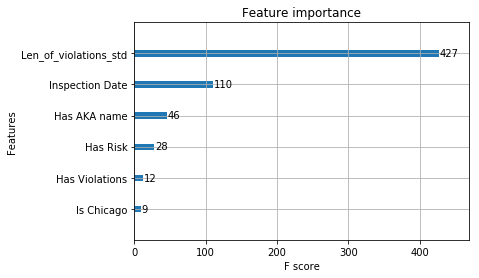

In [65]:
plot_importance(model);
# It looks like having a really long list of violations seems to be related to failing your inspection